In [1]:
#Import the appropriate libraries
import re
import pandas as pd
import numpy as np
import string
import nltk
import warnings
import matplotlib.pyplot as plot
import seaborn

In [2]:
#Initial Setup & import dataset
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

test = pd.read_csv('test_tweets_anuFYb8.csv')
train = pd.read_csv('train_E6oV3lV.csv')
combined = train.append(test, ignore_index = True)

In [3]:
#Preprocess Tweets: Remove items from a tweet that do not add significance to the sentiment.
#1. Remove @usernames
#2. Remove special characters, punctuation, and numbers
#3. Remove words less than 4 characters in length

In [4]:
#Helper function to remove sub-strings from an input string
def removeSubString(input, subString):
    matchesList = re.findall(subString, input)
    
    for match in matchesList:
        input = re.sub(match, '', input)
    
    return input

In [5]:
#1. Remove @usernames
#"@[\w]*" is any word starting with an @ symbol. This line of code will remove all usernames from tweets, as it is
#not important in determing the sentiment of a tweet.
combined['processed_tweet'] = np.vectorize(removeSubString)(combined['tweet'], "@[\w]*")

In [6]:
#2. Remove numbers, punctuation, and special characters from the tweets.
combined['processed_tweet'] = combined['processed_tweet'].str.replace("[^a-zA-Z#]", " ")

In [7]:
#3. Remove words with less than 4 letters as they do not add significance to the tweet.
combined['processed_tweet'] = combined['processed_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [8]:
#Processed tweets:
combined.head()

,id,label,tweet,processed_tweet
0,1,0.0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model love take with time
4,5,0.0,factsguide: society now #motivation,factsguide society #motivation


In [9]:
#Tokenize Tweets: Seperate the Strings (tweets) into individual words
tokenized_tweet = combined['processed_tweet'].apply(lambda x: x.split())

In [10]:
#Stemming: Removing suffixes from words
from nltk.stem.porter import *
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: processed_tweet, dtype: object

In [11]:

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

combined['processed_tweet'] = tokenized_tweet

In [12]:
#Gather all words
all_words = ' '.join([text for text in combined['processed_tweet']])

#Gather all the words in the negative tweets
negative_words = ' '.join([text for text in combined['processed_tweet'][combined['label'] == 1]])

#Gather all the words in the regular tweets
regular_words = ' '.join([text for text in combined['processed_tweet'][combined['label'] == 0]])

In [13]:
#Helper function to get hashtags from a tweet by taking words after a "#" symbol.
def getHashtags(tweets):
    hashtags = []
    for i in tweets:
        hashtag = re.findall(r"#(\w+)",i)
        hashtags.append(hashtag)
    return hashtags

In [14]:
#Create two lists, one for hashtags in the negative tweets and one for the positive tweets.
Negative_Hashtags = getHashtags(combined['processed_tweet'][combined['label'] == 1])
Negative_Hashtags = sum(Negative_Hashtags, [])

Regular_Hashtags = getHashtags(combined['processed_tweet'][combined['label'] == 0])
Regular_Hashtags = sum(Regular_Hashtags, [])

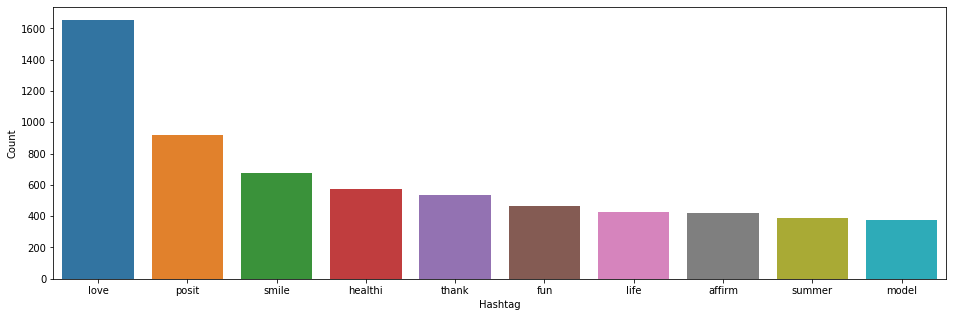

In [15]:
#A figure to display the hashtags sorted by usage.
a = nltk.FreqDist(Regular_Hashtags)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plot.figure(figsize=(16,5))
ax = seaborn.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plot.show()

In [16]:
#Bag-of-words technique is used to meaningfully convey the text numerically.
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combined['processed_tweet'])

In [17]:
#Use a logistic regression model on the Bag-of-words.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:31962,:]
test_biw = bow[31962:,:]

xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['label'], random_state=42, test_size=0.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.5303408146300915